# Import

In [ ]:
!git clone --branch master https://github.com/HanyangHenry-Wang/Treed-BO.git

Cloning into 'Treed-BO'...
remote: Enumerating objects: 104, done.
remote: Counting objects: 100% (104/104), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 104 (delta 63), reused 75 (delta 37), pack-reused 0
Receiving objects: 100% (104/104), 36.99 KiB | 12.33 MiB/s, done.
Resolving deltas: 100% (63/63), done.


In [ ]:
!pip install botorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 490.6/490.6 KB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 KB 37.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.7/730.7 KB 67.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.6/155.6 KB 24.4 MB/s eta 0:00:00


In [ ]:
!pip install GPy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 959.4/959.4 KB 34.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.3/71.3 KB 12.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for GPy: filename=GPy-1.10.0-cp38-cp38-linux_x86_64.whl size=2783625 sha256=192cffef6fcbba68a61c3e47de215400a8f3992900f997c733b5dae71c7698e7
  Stored in directory: /root/.cache/pip/wheels/48/b3/22/31f07cfd7b182ea3703151b7e5a7d6447e3e1ac6aa5c529413
  Created wheel for paramz: filename=paramz-0.9.5-py3-none-any.whl size=102566 sha256=87ddb770a2735d62afd1b266cc9e286bb29d936741673808d505090858863ed1
  Stored in directory: /root/.cache/pip/wheels/66/78/6c/d98cb437834de5e29381786b4ba8a77ea68cca74653ab62713
Successfully built GPy paramz


In [ ]:
cd Treed-BO

/content/Treed-BO


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from treed_gp.partitation import tree_partation
from treed_gp.gp_all_llk import leaf_gp_all_llk
from treed_gp.gp_leaf_llk import leaf_gp_leaf_llk
import GPy

import torch
#from botorch.fit import fit_gpytorch_mll
from botorch.models import SingleTaskGP
from botorch.test_functions import Hartmann
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_mll 
from botorch.acquisition import ExpectedImprovement
from botorch.optim import optimize_acqf
import matplotlib.pyplot as plt
from botorch.models import FixedNoiseGP, ModelListGP

test functions

In [ ]:
from botorch.test_functions import Ackley
from botorch.test_functions import Beale
from botorch.test_functions import Branin
from botorch.test_functions import EggHolder


from botorch.test_functions import synthetic
from __future__ import annotations
import math
from typing import List, Optional, Tuple
import torch
from botorch.test_functions.base import BaseTestProblem
from torch import Tensor

class Paper_function(synthetic.SyntheticTestFunction):

    dim = 2
    _bounds = [(-2., 6.), (-2., 6.)]
    # _optimal_value = -1.0
    # _optimizers = [(0.0, 0.0)]
    _check_grad_at_opt = False

    def evaluate_true(self, X: Tensor) -> Tensor:
        x1, x2 = X[..., 0], X[..., 1] 
        part1 = torch.exp(-x1**2-x2**2)
        return x1*part1

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double

In [ ]:
from gpytorch.kernels import MaternKernel, RBFKernel, IndexKernel
from gpytorch.means import ZeroMean

# Example of Partition

2d

In [ ]:
from random import random

def sep_fun(x):
  noise = random()
  if (x[0]<=5 and x[1]<=5):
    val = 5+noise
  elif (x[0]<=5 and x[1]>5):
    val = 7+noise
  elif (x[0]>5 and x[1]<=5):
    val = 3+noise
  else: 
    val = 0+noise

  return val

In [ ]:
a = 10*(torch.rand(20, 1,device=device, dtype=dtype))
b = 10*(torch.rand(20, 1,device=device, dtype=dtype))  
train_x = torch.column_stack((a, b)).numpy()
train_y = np.array([sep_fun(x) for x in train_x])

In [ ]:
my_tree = tree_partation(train_x,train_y,[[0.,10.],[0.,10.]],2)  
my_tree.return_path([0], ['no'])
leaf_nodes = my_tree.leaf_nodes

[[0.0, 4.9891292526593585], [0.0, 4.719723368076899]]
[[0.0, 4.9891292526593585], [4.719723368076899, 10.0]]
[[4.9891292526593585, 10.0], [0.0, 5.35885565193667]]
[[4.9891292526593585, 10.0], [5.35885565193667, 10.0]]


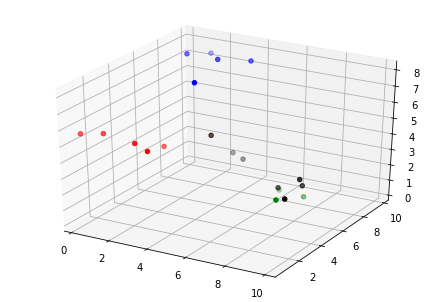

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig=plt.figure()
ax=Axes3D(fig)

color_list = ['red','blue','black','green']
for i,leaf in enumerate(leaf_nodes):
      leaf_gp_temp = leaf_gp_leaf_llk(leaf,my_tree)
      leaf_gp_temp.obtain_data()

      train_X_temp = leaf_gp_temp.X_leaf
      train_obj_temp = leaf_gp_temp.y_leaf
      boundary_temp = leaf_gp_temp.leaf_boundary

      print(boundary_temp)

      x1 = train_X_temp[:,0]
      x2 = train_X_temp[:,1]
      y = train_obj_temp

      ax.scatter(x1,x2,y,c=color_list[i])


[[0.0, 4.9891292526593585], [0.0, 4.719723368076899]]
[[0.0, 4.9891292526593585], [4.719723368076899, 10.0]]
[[4.9891292526593585, 10.0], [0.0, 5.35885565193667]]
[[4.9891292526593585, 10.0], [5.35885565193667, 10.0]]


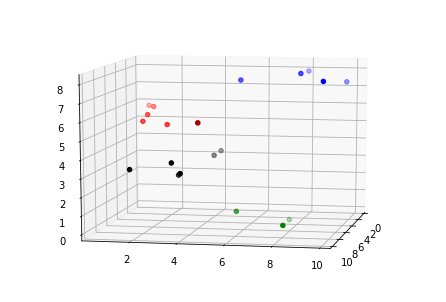

In [ ]:
fig=plt.figure()
ax=Axes3D(fig)

ax.view_init(elev=10., azim=11)

color_list = ['red','blue','black','green']
for i,leaf in enumerate(leaf_nodes):
      leaf_gp_temp = leaf_gp_leaf_llk(leaf,my_tree)
      leaf_gp_temp.obtain_data()

      train_X_temp = leaf_gp_temp.X_leaf
      train_obj_temp = leaf_gp_temp.y_leaf
      boundary_temp = leaf_gp_temp.leaf_boundary

      print(boundary_temp)

      x1 = train_X_temp[:,0]
      x2 = train_X_temp[:,1]
      y = train_obj_temp

      ax.scatter(x1,x2,y,c=color_list[i])

1d

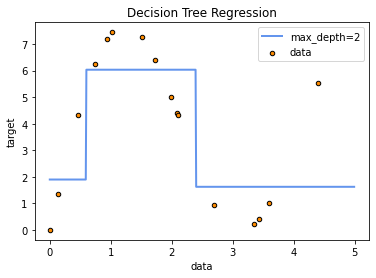

[ 2.39502811  0.59773619 -2.         -2.         -2.        ]


In [ ]:
# Create a random dataset
rng = np.random.RandomState(1)
X = np.sort(5 * rng.rand(16, 1), axis=0)
y = (10*np.sin(X)*np.cos(X/2)).ravel()

# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=2,min_samples_split=2,min_samples_leaf=3)
regr_1.fit(X, y)


# Predict
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
y_1 = regr_1.predict(X_test)


# Plot the results
plt.figure()
plt.scatter(X, y, s=20, edgecolor="black", c="darkorange", label="data")
plt.plot(X_test, y_1, color="cornflowerblue", label="max_depth=2", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

print(regr_1.tree_.threshold)

[[0.0, 0.461692973843989]]
[[0.461692973843989, 2.095972572016474]]
[[2.095972572016474, 5.0]]


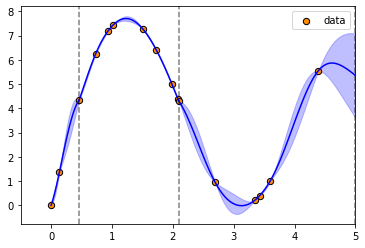

In [ ]:
my_tree = tree_partation(X,y,[[0.,5.]],2)  #change boundary here !!!
my_tree.return_path([0], ['no'])

for leaf in leaf_nodes:
      leaf_gp_temp = leaf_gp_leaf_llk(leaf,my_tree)
      leaf_gp_temp.obtain_data()

      train_X_temp = torch.tensor(leaf_gp_temp.X_leaf)
      train_obj_temp = torch.tensor(leaf_gp_temp.y_leaf).reshape(-1,1)
      boundary_temp = leaf_gp_temp.leaf_boundary
      train_yvar = torch.tensor(10**(-4), device=device, dtype=dtype)

      print(boundary_temp)

      begin = boundary_temp[0][0]
      end = boundary_temp[0][1]

      X_test = torch.linspace(begin, end, steps=100)

      
      model = FixedNoiseGP(train_X_temp, train_obj_temp, train_yvar.expand_as(train_obj_temp)).to(device) #zero mean
      mll = ExactMarginalLogLikelihood(model.likelihood, model) .to(device)
      fit_gpytorch_mll(mll) 

      prediction = model(X_test)

      pre_mean = prediction.mean.detach().numpy()
      pre_std = np.sqrt(prediction.variance.detach().numpy())

      plt.plot(X_test,pre_mean,color='blue' )
      plt.fill_between(X_test, pre_mean-pre_std, pre_mean+pre_std,alpha=0.25,color='blue')
      plt.xlim([-0.5,5])

      plt.axvline(end,color='black',alpha=0.5,linestyle='--')

plt.scatter(X, y, s=40, edgecolor="black", c="darkorange", label="data")
plt.legend()

# Normal BO （constant mean）

In [ ]:
total_record_noramlBO_constantmean = []

for exp in range(20):
  print(exp)

  torch.manual_seed(exp)

  ackley = Branin(negate=True) # I name my function ackley because the first function I tried is ackley

  train_yvar = torch.tensor(10**(-4), device=device, dtype=dtype)
  a = 15*(torch.rand(20, 1,device=device, dtype=dtype))-5. #change boundary here !!!
  b = 15*(torch.rand(20, 1,device=device, dtype=dtype))  ##change boundary here !!!
  train_x = torch.column_stack((a, b))
  train_obj = ackley(train_x).unsqueeze(-1) .to(device)

  

  best_value = train_obj.max()   
  best_value_holder = [best_value] 

  for i in range (45):
    model = FixedNoiseGP(train_x, train_obj, train_yvar.expand_as(train_obj)).to(device)
    mll = ExactMarginalLogLikelihood(model.likelihood, model) .to(device)

    try:
     fit_gpytorch_mll(mll) 
    except:
     pass

    
    best_value =  best_value_holder[-1]
    EI = ExpectedImprovement(model=model, best_f=best_value) .to(device)

    new_point_analytic, _ = optimize_acqf(
        acq_function=EI,
        bounds=torch.tensor([[-5.,0.], [10.,15.]]) .to(device),  #change boundary here !!!
        q=1,
        num_restarts=20,
        raw_samples=100,
        options={},
    )
    new_obj = ackley(new_point_analytic).unsqueeze(-1) .to(device)
    
    train_x = torch.cat((train_x, new_point_analytic))
    train_obj = torch.cat((train_obj, new_obj))
    best_value = train_obj.max()
    best_value_holder.append(best_value)

  best_value_holder = np.array(best_value_holder)
  total_record_noramlBO_constantmean.append(best_value_holder)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


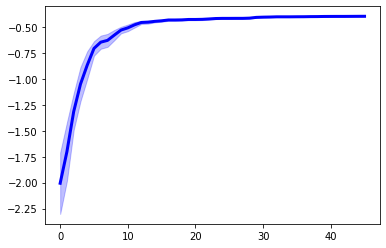

In [ ]:
N = 20
total_record = np.array(total_record_noramlBO_constantmean)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='blue')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='blue',alpha=0.25)

In [ ]:
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

with open('/content/drive/My Drive/treed_BO/noraml_BO_constantmean_Branin.txt', 'w') as f:
    np.savetxt(f, total_record_noramlBO_constantmean)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Treed BO (constant mean)

In [ ]:
total_record_treedBO_constantmean = []

for exp in range(20):

  print(exp)
  torch.manual_seed(exp)

  ackley = Branin(negate=True) # I name my function ackley because the first function I tried is ackley
  a = 15*(torch.rand(20, 1,device=device, dtype=dtype))-5. #change boundary here !!!
  b = 15*(torch.rand(20, 1,device=device, dtype=dtype))  ##change boundary here !!!
  train_x = torch.column_stack((a, b))
  train_obj = ackley(train_x).unsqueeze(-1) 

  best_value = train_obj.max()   
  best_value_holder = [best_value] 


  for j in range (45):

    best_value = best_value_holder[-1]

    choice = [] 
    acq_val = [] 

    train_x = train_x.numpy()
    train_obj = train_obj.numpy()

    my_tree = tree_partation(train_x,train_obj,[[-5.,10.],[0.,15.]],2)  #change boundary here !!!
    my_tree.return_path([0], ['no'])

    leaf_nodes = my_tree.leaf_nodes

    for leaf in leaf_nodes:
      leaf_gp_temp = leaf_gp_leaf_llk(leaf,my_tree)
      leaf_gp_temp.obtain_data()

      train_X_temp = torch.tensor(leaf_gp_temp.X_leaf)
      train_obj_temp = torch.tensor(leaf_gp_temp.y_leaf)
      boundary_temp = leaf_gp_temp.leaf_boundary
      train_yvar = torch.tensor(10**(-4), device=device, dtype=dtype)

      model = FixedNoiseGP(train_X_temp, train_obj_temp, train_yvar.expand_as(train_obj_temp)).to(device)
      mll = ExactMarginalLogLikelihood(model.likelihood, model) .to(device)

      try:
        fit_gpytorch_mll(mll) 
      except:
        pass

      #find the next evaluation
      EI = ExpectedImprovement(model=model, best_f=best_value) .to(device)  

      new_point_analytic, val = optimize_acqf(
          acq_function=EI,
          bounds=torch.tensor(boundary_temp,device=device, dtype=dtype).T,  
          q=1,
          num_restarts=20,
          raw_samples=100,
          options={},
      ) 


      choice.append(new_point_analytic)
      acq_val.append(val)


    idx = np.argmax(np.array(acq_val))
    new_point_analytic = choice[idx]

    new_obj = ackley(new_point_analytic).unsqueeze(-1) .to(device)

    train_x = torch.tensor(train_x)
    train_obj = torch.tensor(train_obj)
    
    train_x = torch.cat((train_x, new_point_analytic))
    train_obj = torch.cat((train_obj, new_obj))
    best_value = train_obj.max()
    best_value_holder.append(best_value)


  best_value_holder = np.array(best_value_holder)
  total_record_treedBO_constantmean.append(best_value_holder)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [ ]:
with open('/content/drive/My Drive/treed_BO/treed_BO_constantmean_Branin.txt', 'w') as f:
    np.savetxt(f, total_record_treedBO_constantmean)

# Plot 

Mounted at /content/drive


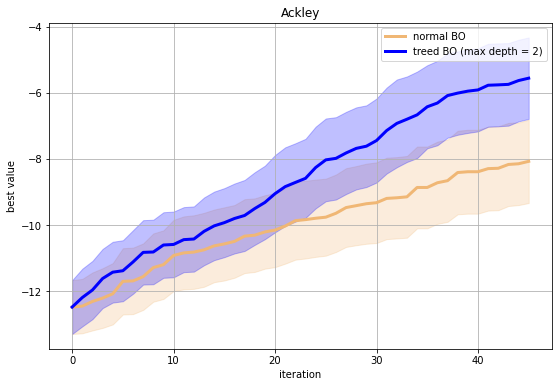

In [ ]:
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

with open('/content/drive/My Drive/treed_BO/treed_BO_constantmean_Ackley.txt', 'r') as f:
    total_record_treedBO_constantmean = np.loadtxt(f)

with open('/content/drive/My Drive/treed_BO/noraml_BO_constantmean_Ackley.txt', 'r') as f:
    total_record_noramlBO_constantmean = np.loadtxt(f)

plt.figure(figsize=(9,6))

N = 20

total_record = np.array(total_record_noramlBO_constantmean)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='#F0B775',label = 'normal BO')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='#F0B775',alpha=0.25)


total_record = np.array(total_record_treedBO_constantmean)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='blue',label = 'treed BO (max depth = 2)')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='blue',alpha=0.25)

plt.xlabel('iteration')
plt.ylabel('best value')
plt.title('Ackley')
plt.grid()
plt.legend()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


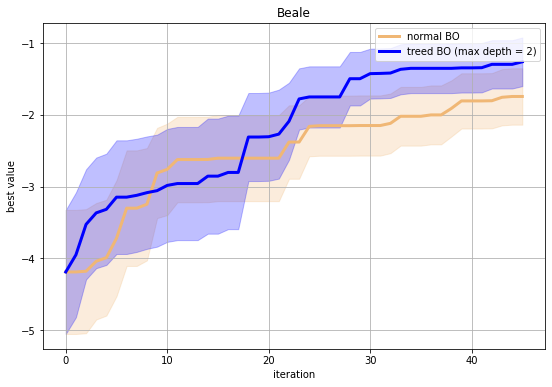

In [ ]:
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

with open('/content/drive/My Drive/treed_BO/treed_BO_constantmean_Beale.txt', 'r') as f:
    total_record_treedBO_constantmean = np.loadtxt(f)

with open('/content/drive/My Drive/treed_BO/noraml_BO_constantmean_Beale.txt', 'r') as f:
    total_record_noramlBO_constantmean = np.loadtxt(f)
plt.figure(figsize=(9,6))

N = 20

total_record = np.array(total_record_noramlBO_constantmean)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='#F0B775',label = 'normal BO')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='#F0B775',alpha=0.25)


total_record = np.array(total_record_treedBO_constantmean)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='blue',label = 'treed BO (max depth = 2)')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='blue',alpha=0.25)

plt.xlabel('iteration')
plt.ylabel('best value')
plt.title('Beale')
plt.grid()
plt.legend()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<Figure size 648x432 with 0 Axes>

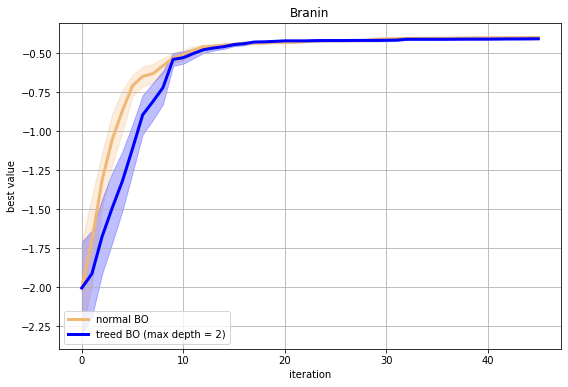

In [ ]:
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

with open('/content/drive/My Drive/treed_BO/treed_BO_constantmean_Branin.txt', 'r') as f:
    total_record_treedBO_constantmean = np.loadtxt(f)

with open('/content/drive/My Drive/treed_BO/noraml_BO_constantmean_Branin.txt', 'r') as f:
    total_record_noramlBO_constantmean = np.loadtxt(f)
plt.figure(figsize=(9,6))


plt.figure(figsize=(9,6))

N = 20

total_record = np.array(total_record_noramlBO_constantmean)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='#F0B775',label = 'normal BO')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='#F0B775',alpha=0.25)


total_record = np.array(total_record_treedBO_constantmean)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='blue',label = 'treed BO (max depth = 2)')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='blue',alpha=0.25)

plt.xlabel('iteration')
plt.ylabel('best value')
plt.title('Branin')
plt.grid()
plt.legend()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


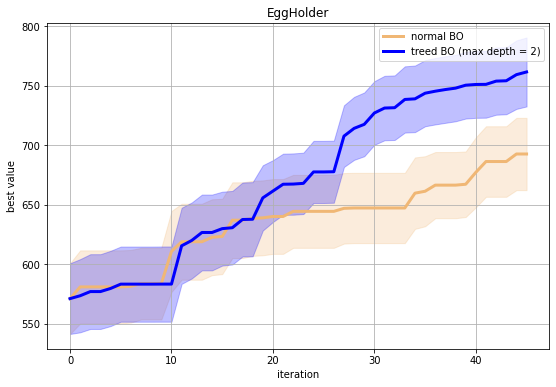

In [ ]:
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

with open('/content/drive/My Drive/treed_BO/treed_BO_constantmean_EggHolder.txt', 'r') as f:
    total_record_treedBO_constantmean = np.loadtxt(f)

with open('/content/drive/My Drive/treed_BO/noraml_BO_constantmean_EggHolder.txt', 'r') as f:
    total_record_noramlBO_constantmean = np.loadtxt(f)
plt.figure(figsize=(9,6))

N = 20

total_record = np.array(total_record_noramlBO_constantmean)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='#F0B775',label = 'normal BO')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='#F0B775',alpha=0.25)


total_record = np.array(total_record_treedBO_constantmean)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='blue',label = 'treed BO (max depth = 2)')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='blue',alpha=0.25)

plt.xlabel('iteration')
plt.ylabel('best value')
plt.title('EggHolder')
plt.grid()
plt.legend()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


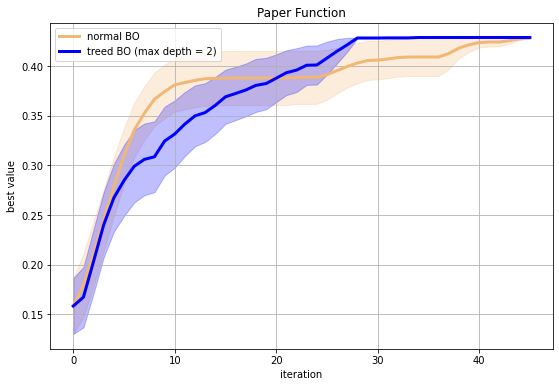

In [ ]:
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

with open('/content/drive/My Drive/treed_BO/treed_BO_constantmean_Paper Function.txt', 'r') as f:
    total_record_treedBO_constantmean = np.loadtxt(f)

with open('/content/drive/My Drive/treed_BO/noraml_BO_constantmean_Paper_function.txt', 'r') as f:
    total_record_noramlBO_constantmean = np.loadtxt(f)
    
plt.figure(figsize=(9,6))

N = 20

total_record = np.array(total_record_noramlBO_constantmean)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='#F0B775',label = 'normal BO')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='#F0B775',alpha=0.25)


total_record = np.array(total_record_treedBO_constantmean)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='blue',label = 'treed BO (max depth = 2)')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='blue',alpha=0.25)

plt.xlabel('iteration')
plt.ylabel('best value')
plt.title('Paper Function')
plt.grid()
plt.legend()

# When is treed BO worse? 

In [ ]:
class GP_function(synthetic.SyntheticTestFunction):
    def __init__(
        self,
        observation_X,
        observation_Y,
        seed = 0,
        dim=1,
        lengthscale = 1.5,
        variance = 5,
        noise_std: Optional[float] = None,
        negate: bool = False,
        bounds: Optional[List[Tuple[float, float]]] = None,
    ) -> None:
        self.lengthscale = lengthscale
        self.variance = variance 
        self.observation_X = observation_X
        self.observation_Y = observation_Y

        self.seed = seed

        self.dim = dim
        self._bounds = [(0, 10.0) for _ in range(self.dim)]
        super().__init__(noise_std=noise_std, negate=negate, bounds=bounds)

    def evaluate_true(self, X: Tensor) -> Tensor:
      
        np.random.seed(self.seed) 

        observation_X = np.array(self.observation_X)
        observation_Y = np.array(self.observation_Y)

        kernel = GPy.kern.RBF(input_dim=self.dim,variance=self.variance,lengthscale=self.lengthscale)
        m = GPy.models.GPRegression(observation_X.reshape(-1,self.dim),observation_Y.reshape(-1,1),kernel)
        m.Gaussian_noise.variance.fix(0.0)

        X = np.array(X)
        result = m.posterior_samples_f(X.reshape(-1,self.dim),size=1)
        return torch.tensor(result)

In [ ]:
total_record_noramlBO_constantmean = []    #Normal Bayesian Optimization  

for exp in range(20):
  print(exp)

  torch.manual_seed(exp)
  np.random.seed(exp) 

  X_sample1=np.array([[0.,0.]])
  Y_sample1=np.array([[0.]])

  kernel1 = GPy.kern.RBF(input_dim=2,variance=5,lengthscale=1.5)
  m1 = GPy.models.GPRegression(X_sample1,Y_sample1,kernel1)
  m1.Gaussian_noise.variance.fix(0.0)
  
  X1 = np.array(10*(torch.rand(20, 2,device=device, dtype=dtype))) 
  Y1 = m1.posterior_samples_f(X1.reshape(-1,2),size=1).reshape(-1,1)

  train_yvar = torch.tensor(10**(-4), device=device, dtype=dtype)
  train_x = torch.tensor(X1).to(device)
  train_obj = torch.tensor(Y1).to(device)

  best_value = train_obj.max()   
  best_value_holder = [best_value] 


  for j in range (20):

    ackley = GP_function(observation_X=train_x,observation_Y=train_obj,seed=j, dim=2,lengthscale = 1.5,variance = 5)
    
    model = FixedNoiseGP(train_x, train_obj, train_yvar.expand_as(train_obj)).to(device)
    mll = ExactMarginalLogLikelihood(model.likelihood, model) .to(device)

    try:
     fit_gpytorch_mll(mll) 
    except:
     pass
    
    best_value =  best_value_holder[-1]
    EI = ExpectedImprovement(model=model, best_f=best_value) .to(device)

    new_point_analytic, _ = optimize_acqf(
        acq_function=EI,
        bounds=torch.tensor([[0.,0.], [10.,10.]]) .to(device),  
        q=1,
        num_restarts=20,
        raw_samples=100,
        options={},
    )
    new_obj = ackley(new_point_analytic) .reshape(-1,1).to(device)
    
    train_x = torch.cat((train_x, new_point_analytic))
    train_obj = torch.cat((train_obj, new_obj))
    best_value = train_obj.max()
    best_value_holder.append(best_value)

  best_value_holder = np.array(best_value_holder)
  total_record_noramlBO_constantmean.append(best_value_holder)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


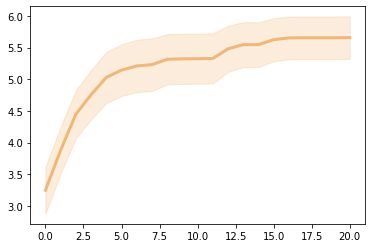

In [ ]:
N = 20

total_record = np.array(total_record_noramlBO_constantmean)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='#F0B775',label = 'normal BO')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='#F0B775',alpha=0.25)

In [ ]:
total_record_treedBO_constantmean = []

for exp in range(20):

  print(exp)

  torch.manual_seed(exp)
  np.random.seed(exp)
  
  X_sample1=np.array([[0.,0.]])
  Y_sample1=np.array([[0.]])

  kernel1 = GPy.kern.RBF(input_dim=2,variance=5,lengthscale=1.5)
  m1 = GPy.models.GPRegression(X_sample1,Y_sample1,kernel1)
  m1.Gaussian_noise.variance.fix(0.0)
  
  X1 = np.array(10*(torch.rand(20, 2,device=device, dtype=dtype))) 
  Y1 = m1.posterior_samples_f(X1.reshape(-1,2),size=1).reshape(-1,1)

  train_x = torch.tensor(X1).to(device)
  train_obj = torch.tensor(Y1).to(device)


  best_value = train_obj.max()   
  best_value_holder = [best_value] 


  for j in range (20):

    ackley = GP_function(observation_X=train_x,observation_Y=train_obj,seed=j, dim=2,lengthscale = 1.5,variance = 5)

    best_value = best_value_holder[-1]

    choice = [] 
    acq_val = [] 

    train_x = train_x.numpy()
    train_obj = train_obj.numpy()

    my_tree = tree_partation(train_x,train_obj,[[0.,10.],[0.,10.]],2)  #change boundary here !!!
    my_tree.return_path([0], ['no'])

    leaf_nodes = my_tree.leaf_nodes

    print('here is the boundary')
    for leaf in leaf_nodes:
      leaf_gp_temp = leaf_gp_leaf_llk(leaf,my_tree)
      leaf_gp_temp.obtain_data()

      train_X_temp = torch.tensor(leaf_gp_temp.X_leaf)
      train_obj_temp = torch.tensor(leaf_gp_temp.y_leaf)
      boundary_temp = leaf_gp_temp.leaf_boundary
      train_yvar = torch.tensor(10**(-4), device=device, dtype=dtype)

      print(boundary_temp)

      model = FixedNoiseGP(train_X_temp, train_obj_temp, train_yvar.expand_as(train_obj_temp)).to(device)
      mll = ExactMarginalLogLikelihood(model.likelihood, model) .to(device)

      try:
        fit_gpytorch_mll(mll) 
      except:
        pass

      #find the next evaluation
      EI = ExpectedImprovement(model=model, best_f=best_value) .to(device)  

      new_point_analytic, val = optimize_acqf(
          acq_function=EI,
          bounds=torch.tensor(boundary_temp,device=device, dtype=dtype).T,  
          q=1,
          num_restarts=20,
          raw_samples=100,
          options={},
      ) 


      choice.append(new_point_analytic)
      acq_val.append(val)


    idx = np.argmax(np.array(acq_val))
    new_point_analytic = choice[idx]

    new_obj = ackley(new_point_analytic) .reshape(-1,1).to(device)

    train_x = torch.tensor(train_x)
    train_obj = torch.tensor(train_obj)
    
    train_x = torch.cat((train_x, new_point_analytic))
    train_obj = torch.cat((train_obj, new_obj))
    best_value = train_obj.max()
    best_value_holder.append(best_value)


  best_value_holder = np.array(best_value_holder)
  total_record_treedBO_constantmean.append(best_value_holder)

0
here is the boundary
[[0.0, 4.072815743644416], [0.0, 10.0]]
[[4.072815743644416, 4.815065022187253], [0.0, 10.0]]
[[4.815065022187253, 10.0], [0.0, 3.679702043294857]]
[[4.815065022187253, 10.0], [3.679702043294857, 10.0]]
here is the boundary
[[0.0, 4.072815743644416], [0.0, 10.0]]
[[4.072815743644416, 4.815065022187253], [0.0, 10.0]]
[[4.815065022187253, 10.0], [0.0, 4.408004990443595]]
[[4.815065022187253, 10.0], [4.408004990443595, 10.0]]
here is the boundary
[[0.0, 4.072815743644416], [0.0, 10.0]]
[[4.072815743644416, 4.815065022187253], [0.0, 10.0]]
[[4.815065022187253, 10.0], [0.0, 4.408004990443595]]
[[4.815065022187253, 10.0], [4.408004990443595, 10.0]]
here is the boundary
[[0.0, 4.072815743644416], [0.0, 10.0]]
[[4.072815743644416, 4.815065022187253], [0.0, 10.0]]
[[4.815065022187253, 8.983556356184852], [0.0, 10.0]]
[[8.983556356184852, 10.0], [0.0, 10.0]]
here is the boundary
[[0.0, 4.072815743644416], [0.0, 10.0]]
[[4.072815743644416, 4.815065022187253], [0.0, 10.0]]
[

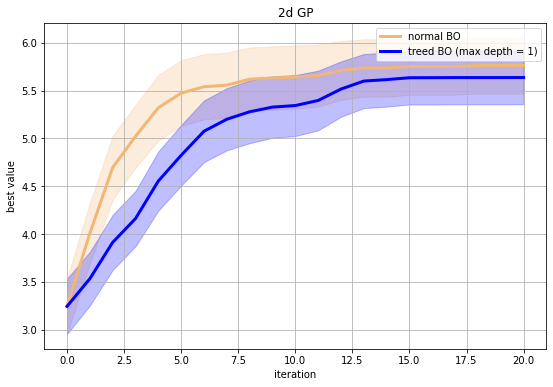

In [ ]:
plt.figure(figsize=(9,6))

N = 20

total_record = np.array(total_record_noramlBO_constantmean)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='#F0B775',label = 'normal BO')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='#F0B775',alpha=0.25)


total_record = np.array(total_record_treedBO_constantmean)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='blue',label = 'treed BO (max depth = 1)')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='blue',alpha=0.25)

plt.xlabel('iteration')
plt.ylabel('best value')
plt.title('2d GP')
plt.grid()
plt.legend()

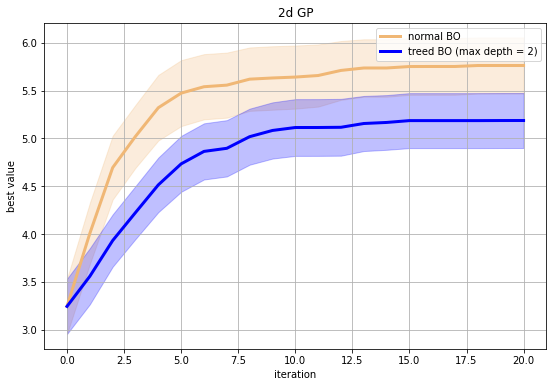

In [ ]:
plt.figure(figsize=(9,6))

N = 20

total_record = np.array(total_record_noramlBO_constantmean)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='#F0B775',label = 'normal BO')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='#F0B775',alpha=0.25)


total_record = np.array(total_record_treedBO_constantmean)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='blue',label = 'treed BO (max depth = 2)')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='blue',alpha=0.25)

plt.xlabel('iteration')
plt.ylabel('best value')
plt.title('2d GP')
plt.grid()
plt.legend()

# Normal BO (zero mean)

In [ ]:
total_record_noramlBO_zeromean = []

for exp in range(20):
  print(exp)

  torch.manual_seed(exp)

  ackley = Ackley(dim=2, negate=True) # I name my function ackley because the first function I tried is ackley

  train_yvar = torch.tensor(10**(-4), device=device, dtype=dtype)
  a = 2*32.768*(torch.rand(20, 1,device=device, dtype=dtype))-32.768 #change boundary here !!!
  b = 2*32.768*(torch.rand(20, 1,device=device, dtype=dtype))-32.768  ##change boundary here !!!
  train_x = torch.column_stack((a, b))
  train_obj = ackley(train_x).unsqueeze(-1) .to(device)

  

  best_value = train_obj.max()   
  best_value_holder = [best_value] 

  for i in range (45):
    model = FixedNoiseGP(train_x, train_obj, train_yvar.expand_as(train_obj),mean_module = ZeroMean()).to(device) #zero mean
    mll = ExactMarginalLogLikelihood(model.likelihood, model) .to(device)

    try:
     fit_gpytorch_mll(mll) 
    except:
     pass

    
    best_value =  best_value_holder[-1]
    EI = ExpectedImprovement(model=model, best_f=best_value) .to(device)

    new_point_analytic, _ = optimize_acqf(
        acq_function=EI,
        bounds=torch.tensor([[-32.768,-32.768], [32.768,32.768]]) .to(device),  #change boundary here !!!
        q=1,
        num_restarts=20,
        raw_samples=100,
        options={},
    )
    new_obj = ackley(new_point_analytic).unsqueeze(-1) .to(device)
    
    train_x = torch.cat((train_x, new_point_analytic))
    train_obj = torch.cat((train_obj, new_obj))
    best_value = train_obj.max()
    best_value_holder.append(best_value)

  best_value_holder = np.array(best_value_holder)
  total_record_noramlBO_zeromean.append(best_value_holder)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [ ]:
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

with open('/content/drive/My Drive/treed_BO/noraml_BO_zeromean_EggHolder.txt', 'w') as f:
    np.savetxt(f, total_record_noramlBO_zeromean)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Treed BO (zero mean)

In [ ]:
total_record_treedBO_zeromean = []

for exp in range(1):

  print(exp)
  torch.manual_seed(2)

  ackley = Ackley(dim=2,negate=True) # I name my function ackley because the first function I tried is ackley
  a = 2*32.768*(torch.rand(20, 1,device=device, dtype=dtype))-32.768 #change boundary here !!!
  b = 2*32.768*(torch.rand(20, 1,device=device, dtype=dtype))-32.768  ##change boundary here !!!
  train_x = torch.column_stack((a, b))
  train_obj = ackley(train_x).unsqueeze(-1) 

  best_value = train_obj.max()   
  best_value_holder = [best_value] 


  for j in range (2):

    best_value = best_value_holder[-1]

    choice = [] 
    acq_val = [] 

    train_x = train_x.numpy()
    train_obj = train_obj.numpy()

    my_tree = tree_partation(train_x,train_obj,[[-32.768,32.768],[-32.768,32.768]],2)  #change boundary here !!!
    my_tree.return_path([0], ['no'])

    leaf_nodes = my_tree.leaf_nodes

    for leaf in leaf_nodes:
      leaf_gp_temp = leaf_gp_leaf_llk(leaf,my_tree)
      leaf_gp_temp.obtain_data()

      train_X_temp = torch.tensor(leaf_gp_temp.X_leaf)
      train_obj_temp = torch.tensor(leaf_gp_temp.y_leaf)
      boundary_temp = leaf_gp_temp.leaf_boundary
      train_yvar = torch.tensor(10**(-4), device=device, dtype=dtype)

      # covar_module =  RBFKernel()  #define my own kernel here
      # model = FixedNoiseGP(train_X_temp, train_obj_temp, train_yvar.expand_as(train_obj_temp),covar_module=covar_module).to(device)

      model = FixedNoiseGP(train_X_temp, train_obj_temp, train_yvar.expand_as(train_obj_temp),mean_module = ZeroMean()).to(device) #zero mean
      mll = ExactMarginalLogLikelihood(model.likelihood, model) .to(device)

      # print(train_X_temp)
      # print('leaf is ',leaf)
      
      # model.covar_module.lengthscale = 1.

      # print('before training: ',model.covar_module.lengthscale)
      try:
        fit_gpytorch_mll(mll) 
      except:
        pass

      # print('the lengthscale of model is: ',model.covar_module.lengthscale )


      #find the next evaluation
      EI = ExpectedImprovement(model=model, best_f=best_value) .to(device)  

      new_point_analytic, val = optimize_acqf(
          acq_function=EI,
          bounds=torch.tensor(boundary_temp,device=device, dtype=dtype).T,  
          q=1,
          num_restarts=20,
          raw_samples=100,
          options={},
      ) 


      choice.append(new_point_analytic)
      acq_val.append(val)


    idx = np.argmax(np.array(acq_val))
    new_point_analytic = choice[idx]

    new_obj = ackley(new_point_analytic).unsqueeze(-1) .to(device)

    train_x = torch.tensor(train_x)
    train_obj = torch.tensor(train_obj)
    
    train_x = torch.cat((train_x, new_point_analytic))
    train_obj = torch.cat((train_obj, new_obj))
    best_value = train_obj.max()
    best_value_holder.append(best_value)


  best_value_holder = np.array(best_value_holder)
  total_record_treedBO_zeromean.append(best_value_holder)

0
tensor([[-26.4166,  13.5502],
        [-27.3881, -30.8826],
        [-25.3018, -23.5405]], dtype=torch.float64)
leaf is  2
before training:  tensor([[1.]], dtype=torch.float64, grad_fn=<SoftplusBackward0>)
the lengthscale of model is:  tensor([[1.0000]], dtype=torch.float64, grad_fn=<SoftplusBackward0>)
tensor([[-24.8770,  24.4176],
        [-15.2733, -31.1452],
        [-19.8542,  22.8437],
        [-25.3018, -23.5405]], dtype=torch.float64)
leaf is  3
before training:  tensor([[1.]], dtype=torch.float64, grad_fn=<SoftplusBackward0>)
the lengthscale of model is:  tensor([[1.0003]], dtype=torch.float64, grad_fn=<SoftplusBackward0>)
tensor([[  2.6386,  12.8010],
        [  1.6851, -23.9605],
        [-15.2733, -31.1452],
        [ -2.4732,  -3.6548],
        [  7.8461,   3.4718],
        [ -8.7568,  -9.4274]], dtype=torch.float64)
leaf is  5
before training:  tensor([[1.]], dtype=torch.float64, grad_fn=<SoftplusBackward0>)
the lengthscale of model is:  tensor([[1.0000]], dtype=torch.f

In [ ]:
train_obj_temp.shape

torch.Size([4, 1])

In [ ]:
# import numpy as np
# from google.colab import drive
# drive.mount('/content/drive')

# with open('/content/drive/My Drive/treed_BO/treed_BO_zeromean_EggHolder.txt', 'w') as f:
#     np.savetxt(f, total_record_treedBO_zeromean)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Plot

In [ ]:
from google.colab import files

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


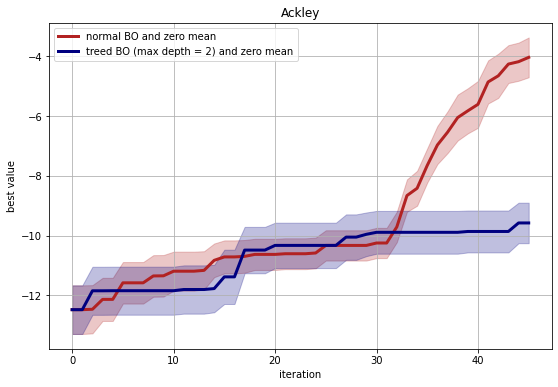

In [ ]:
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

with open('/content/drive/My Drive/treed_BO/treed_BO_zeromean_Ackley.txt', 'r') as f:
    total_record_treedBO_zerotmean = np.loadtxt(f)

with open('/content/drive/My Drive/treed_BO/noraml_BO_zeromean_Ackley.txt', 'r') as f:
    total_record_noramlBO_zeromean = np.loadtxt(f)

with open('/content/drive/My Drive/treed_BO/treed_BO_constantmean_Ackley.txt', 'r') as f:
    total_record_treedBO_constantmean = np.loadtxt(f)

with open('/content/drive/My Drive/treed_BO/noraml_BO_constantmean_Ackley.txt', 'r') as f:
    total_record_noramlBO_constantmean = np.loadtxt(f)


plt.figure(figsize=(9,6))

N = 20

total_record = np.array(total_record_noramlBO_zeromean)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='firebrick',label = 'normal BO and zero mean')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='firebrick',alpha=0.25)


total_record = np.array(total_record_treedBO_zerotmean)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='navy',label = 'treed BO (max depth = 2) and zero mean')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='navy',alpha=0.25)


# total_record = np.array(total_record_noramlBO_constantmean)
# mean = np.mean(total_record,axis=0)
# std = np.std(total_record,axis=0)
# iter = np.array(range(mean.shape[0]))
# plt.plot(mean,linewidth=3,color='coral',label = 'normal BO and constant mean ')
# plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='coral',alpha=0.25)


# total_record = np.array(total_record_treedBO_constantmean)
# mean = np.mean(total_record,axis=0)
# std = np.std(total_record,axis=0)
# iter = np.array(range(mean.shape[0]))
# plt.plot(mean,linewidth=3,color='skyblue',label = 'treed BO (max depth = 2) and constant mean')
# plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='skyblue',alpha=0.25)

plt.xlabel('iteration')
plt.ylabel('best value')
plt.title('Ackley')
plt.grid()
plt.legend()


# plt.savefig("Ackley.png")
# files.download("Ackley.png") 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


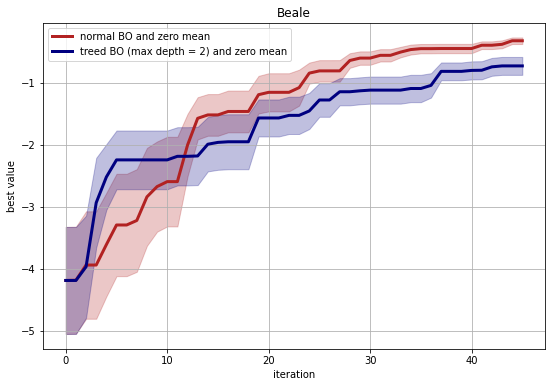

In [ ]:
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

with open('/content/drive/My Drive/treed_BO/treed_BO_zeromean_Beale.txt', 'r') as f:
    total_record_treedBO_zerotmean = np.loadtxt(f)

with open('/content/drive/My Drive/treed_BO/noraml_BO_zeromean_Beale.txt', 'r') as f:
    total_record_noramlBO_zeromean = np.loadtxt(f)


with open('/content/drive/My Drive/treed_BO/treed_BO_constantmean_Beale.txt', 'r') as f:
    total_record_treedBO_constantmean = np.loadtxt(f)

with open('/content/drive/My Drive/treed_BO/noraml_BO_constantmean_Beale.txt', 'r') as f:
    total_record_noramlBO_constantmean = np.loadtxt(f)

plt.figure(figsize=(9,6))

N = 20

total_record = np.array(total_record_noramlBO_zeromean)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='firebrick',label = 'normal BO and zero mean')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='firebrick',alpha=0.25)


total_record = np.array(total_record_treedBO_zerotmean)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='navy',label = 'treed BO (max depth = 2) and zero mean')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='navy',alpha=0.25)


# total_record = np.array(total_record_noramlBO_constantmean)
# mean = np.mean(total_record,axis=0)
# std = np.std(total_record,axis=0)
# iter = np.array(range(mean.shape[0]))
# plt.plot(mean,linewidth=3,color='coral',label = 'normal BO and constant mean ')
# plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='coral',alpha=0.25)


# total_record = np.array(total_record_treedBO_constantmean)
# mean = np.mean(total_record,axis=0)
# std = np.std(total_record,axis=0)
# iter = np.array(range(mean.shape[0]))
# plt.plot(mean,linewidth=3,color='skyblue',label = 'treed BO (max depth = 2) and constant mean')
# plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='skyblue',alpha=0.25)


plt.xlabel('iteration')
plt.ylabel('best value')
plt.title('Beale')
plt.grid()
plt.legend()

# plt.savefig("Beale.png")
# files.download("Beale.png") 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

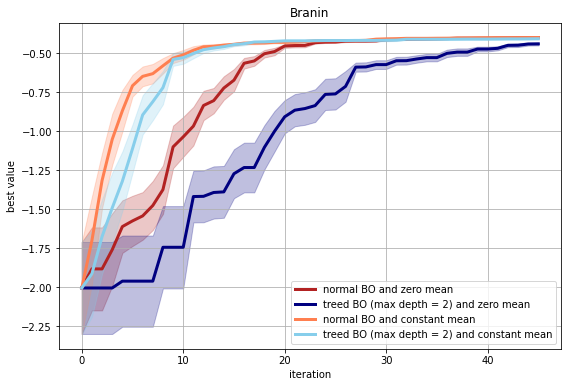

In [ ]:
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

with open('/content/drive/My Drive/treed_BO/treed_BO_zeromean_Branin.txt', 'r') as f:
    total_record_treedBO_zerotmean = np.loadtxt(f)

with open('/content/drive/My Drive/treed_BO/noraml_BO_zeromean_Branin.txt', 'r') as f:
    total_record_noramlBO_zeromean = np.loadtxt(f)

with open('/content/drive/My Drive/treed_BO/treed_BO_constantmean_Branin.txt', 'r') as f:
    total_record_treedBO_constantmean = np.loadtxt(f)

with open('/content/drive/My Drive/treed_BO/noraml_BO_constantmean_Branin.txt', 'r') as f:
    total_record_noramlBO_constantmean = np.loadtxt(f)


plt.figure(figsize=(9,6))

N = 20

total_record = np.array(total_record_noramlBO_zeromean)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='firebrick',label = 'normal BO and zero mean')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='firebrick',alpha=0.25)


total_record = np.array(total_record_treedBO_zerotmean)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='navy',label = 'treed BO (max depth = 2) and zero mean')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='navy',alpha=0.25)


total_record = np.array(total_record_noramlBO_constantmean)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='coral',label = 'normal BO and constant mean ')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='coral',alpha=0.25)


total_record = np.array(total_record_treedBO_constantmean)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='skyblue',label = 'treed BO (max depth = 2) and constant mean')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='skyblue',alpha=0.25)

plt.xlabel('iteration')
plt.ylabel('best value')
plt.title('Branin')
plt.grid()
plt.legend()


plt.savefig("Branin.png")
files.download("Branin.png") 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

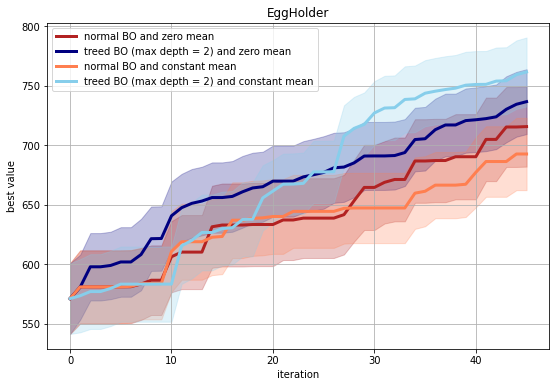

In [ ]:
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

with open('/content/drive/My Drive/treed_BO/treed_BO_zeromean_EggHolder.txt', 'r') as f:
    total_record_treedBO_zerotmean = np.loadtxt(f)

with open('/content/drive/My Drive/treed_BO/noraml_BO_zeromean_EggHolder.txt', 'r') as f:
    total_record_noramlBO_zeromean = np.loadtxt(f)

with open('/content/drive/My Drive/treed_BO/treed_BO_constantmean_EggHolder.txt', 'r') as f:
    total_record_treedBO_constantmean = np.loadtxt(f)

with open('/content/drive/My Drive/treed_BO/noraml_BO_constantmean_EggHolder.txt', 'r') as f:
    total_record_noramlBO_constantmean = np.loadtxt(f)


plt.figure(figsize=(9,6))

N = 20

total_record = np.array(total_record_noramlBO_zeromean)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='firebrick',label = 'normal BO and zero mean')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='firebrick',alpha=0.25)


total_record = np.array(total_record_treedBO_zerotmean)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='navy',label = 'treed BO (max depth = 2) and zero mean')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='navy',alpha=0.25)


total_record = np.array(total_record_noramlBO_constantmean)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='coral',label = 'normal BO and constant mean ')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='coral',alpha=0.25)


total_record = np.array(total_record_treedBO_constantmean)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='skyblue',label = 'treed BO (max depth = 2) and constant mean')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='skyblue',alpha=0.25)

plt.xlabel('iteration')
plt.ylabel('best value')
plt.title('EggHolder')
plt.grid()
plt.legend()

plt.savefig("EggHolder.png")
files.download("EggHolder.png") 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

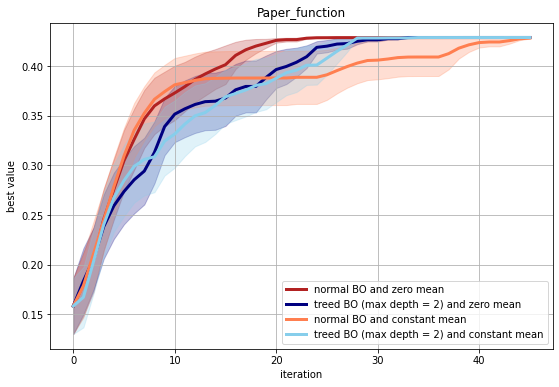

In [ ]:
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

with open('/content/drive/My Drive/treed_BO/treed_BO_zeromean_Paper_function.txt', 'r') as f:
    total_record_treedBO_zerotmean = np.loadtxt(f)

with open('/content/drive/My Drive/treed_BO/noraml_BO_zeromean_Paper_function.txt', 'r') as f:
    total_record_noramlBO_zeromean = np.loadtxt(f)

with open('/content/drive/My Drive/treed_BO/treed_BO_constantmean_Paper_function.txt', 'r') as f:
    total_record_treedBO_constantmean = np.loadtxt(f)

with open('/content/drive/My Drive/treed_BO/noraml_BO_constantmean_Paper_function.txt', 'r') as f:
    total_record_noramlBO_constantmean = np.loadtxt(f)


plt.figure(figsize=(9,6))

N = 20

total_record = np.array(total_record_noramlBO_zeromean)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='firebrick',label = 'normal BO and zero mean')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='firebrick',alpha=0.25)


total_record = np.array(total_record_treedBO_zerotmean)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='navy',label = 'treed BO (max depth = 2) and zero mean')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='navy',alpha=0.25)


total_record = np.array(total_record_noramlBO_constantmean)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='coral',label = 'normal BO and constant mean ')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='coral',alpha=0.25)


total_record = np.array(total_record_treedBO_constantmean)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='skyblue',label = 'treed BO (max depth = 2) and constant mean')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='skyblue',alpha=0.25)

plt.xlabel('iteration')
plt.ylabel('best value')
plt.title('Paper_function')
plt.grid()
plt.legend()

plt.savefig("Paper_function.png")
files.download("Paper_function.png") 

# Compare leaf likelihood and all likelihood (zero mean)

In [ ]:
torch.manual_seed(1)

ackley = Branin(negate=True) # I name my function ackley because the first function I tried is ackley

train_yvar = torch.tensor(10**(-4), device=device, dtype=dtype)
a = 15*(torch.rand(20, 1,device=device, dtype=dtype))-5. #change boundary here !!!
b = 15*(torch.rand(20, 1,device=device, dtype=dtype))  ##change boundary here !!!
train_x = torch.column_stack((a, b))
train_obj = ackley(train_x).unsqueeze(-1) .to(device)



best_value = train_obj.max()   
best_value_holder = [best_value] 

covar_module =  RBFKernel()  #define my own kernel here
model = FixedNoiseGP(train_x, train_obj, train_yvar.expand_as(train_obj),mean_module = ZeroMean(),covar_module=covar_module).to(device)
mll = ExactMarginalLogLikelihood(model.likelihood, model) .to(device)

In [ ]:
model.covar_module.lengthscale.shape

torch.Size([1, 1])

# All Likelihood

In [ ]:
total_record_BO_zeromean_all_llk = []

for exp in range(20):

  print(exp)
  torch.manual_seed(exp)

  ackley = EggHolder(negate=True) # I name my function ackley because the first function I tried is ackley
  a = 2*512*(torch.rand(20, 1,device=device, dtype=dtype))-512. #change boundary here !!!
  b = 2*512*(torch.rand(20, 1,device=device, dtype=dtype))-512.  ##change boundary here !!!
  train_x = torch.column_stack((a, b))
  train_obj = ackley(train_x).unsqueeze(-1) 

  best_value = train_obj.max()   
  best_value_holder = [best_value] 


  for j in range (45):

    #print(j)

    best_value = best_value_holder[-1]

    choice = [] 
    acq_val = [] 

    train_x = train_x.numpy()
    train_obj = train_obj.numpy()

    my_tree = tree_partation(train_x,train_obj,[[-512,512],[-512,512]],2)  #change boundary here !!!
    my_tree.return_path([0], ['no'])

    leaf_nodes = my_tree.leaf_nodes

    # print('data X: ',train_x)
    # print('data y: ',train_obj)

    for leaf in leaf_nodes:
      leaf_gp_temp = leaf_gp_all_llk(leaf,my_tree)
      leaf_gp_temp.train_gp()

      train_X_temp = torch.tensor(leaf_gp_temp.X_leaf)
      train_obj_temp = torch.tensor(leaf_gp_temp.y_leaf)
      boundary_temp = leaf_gp_temp.leaf_boundary
      train_yvar = torch.tensor(10**(-4), device=device, dtype=dtype)


      lengthscale = leaf_gp_temp.lengthscale
      boundary = leaf_gp_temp.leaf_boundary


      print ("in leaf node {}, the lengthscale is {} and the boundary is {}".format(leaf,lengthscale,boundary))
      
      covar_module =  RBFKernel()  #define my own kernel here
      model = FixedNoiseGP(train_X_temp, train_obj_temp, train_yvar.expand_as(train_obj_temp),mean_module = ZeroMean(),covar_module=covar_module).to(device)
      model.covar_module.lengthscale = torch.tensor([lengthscale]).reshape(1,1)
      #mll = ExactMarginalLogLikelihood(model.likelihood, model) .to(device)

  #     try:
  #       fit_gpytorch_mll(mll) 
  #     except:
  #       pass

      #find the next evaluation
      EI = ExpectedImprovement(model=model, best_f=best_value) .to(device)  

      new_point_analytic, val = optimize_acqf(
          acq_function=EI,
          bounds=torch.tensor(boundary_temp,device=device, dtype=dtype).T,  
          q=1,
          num_restarts=20,
          raw_samples=100,
          options={},
      ) 


      choice.append(new_point_analytic)
      acq_val.append(val)

      print('the lengthscale of model is: ',model.covar_module.lengthscale )
      print('*********************')


    idx = np.argmax(np.array(acq_val))
    new_point_analytic = choice[idx]

    new_obj = ackley(new_point_analytic).unsqueeze(-1) .to(device)

    train_x = torch.tensor(train_x)
    train_obj = torch.tensor(train_obj)
    
    train_x = torch.cat((train_x, new_point_analytic))
    train_obj = torch.cat((train_obj, new_obj))
    best_value = train_obj.max()
    best_value_holder.append(best_value)


  best_value_holder = np.array(best_value_holder)
  total_record_BO_zeromean_all_llk.append(best_value_holder)

Streaming output truncated to the last 5000 lines.
*********************
in leaf node 5, the lengthscale is [10.3842947] and the boundary is [[-512, -499.25966640178723], [-0.65030271236202, 512]]
the lengthscale of model is:  tensor([[10.3843]], dtype=torch.float64, grad_fn=<SoftplusBackward0>)
*********************
in leaf node 6, the lengthscale is [11.56199519] and the boundary is [[-499.25966640178723, 512], [-0.65030271236202, 512]]
the lengthscale of model is:  tensor([[11.5620]], dtype=torch.float64, grad_fn=<SoftplusBackward0>)
*********************
in leaf node 2, the lengthscale is [8.80311012] and the boundary is [[-512, 223.39249453167724], [-512, -0.65030271236202]]
the lengthscale of model is:  tensor([[8.8031]], dtype=torch.float64, grad_fn=<SoftplusBackward0>)
*********************
in leaf node 3, the lengthscale is [8.3442179] and the boundary is [[223.39249453167724, 512], [-512, -0.65030271236202]]
the lengthscale of model is:  tensor([[8.3442]], dtype=torch.float64

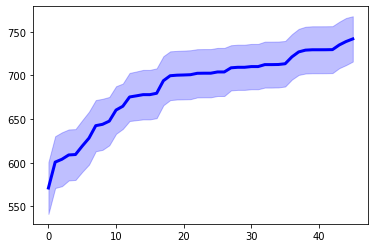

In [ ]:
N = 20
total_record = np.array(total_record_BO_zeromean_all_llk)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='blue')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='blue',alpha=0.25)

In [ ]:
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

with open('/content/drive/My Drive/treed_BO/treed_BO_all_llk_EggHolder.txt', 'w') as f:
    np.savetxt(f, total_record_BO_zeromean_all_llk)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Leaf Likelihood

In [ ]:
total_record_BO_zeromean_leaf_llk = []

for exp in range(20):

  print(exp)
  torch.manual_seed(exp)

  ackley = EggHolder(negate=True) # I name my function ackley because the first function I tried is ackley
  a = 2*512*(torch.rand(20, 1,device=device, dtype=dtype))-512. #change boundary here !!!
  b = 2*512*(torch.rand(20, 1,device=device, dtype=dtype))-512.  ##change boundary here !!!
  train_x = torch.column_stack((a, b))
  train_obj = ackley(train_x).unsqueeze(-1) 

  best_value = train_obj.max()   
  best_value_holder = [best_value] 


  for j in range (45):

    print(j)

    best_value = best_value_holder[-1]

    choice = [] 
    acq_val = [] 

    train_x = train_x.numpy()
    train_obj = train_obj.numpy()

    my_tree = tree_partation(train_x,train_obj,[[-512,512],[-512,512]],2)  #change boundary here !!!
    my_tree.return_path([0], ['no'])

    leaf_nodes = my_tree.leaf_nodes

    # print('data X: ',train_x)
    # print('data y: ',train_obj)

    for leaf in leaf_nodes:
      leaf_gp_temp = leaf_gp_leaf_llk(leaf,my_tree)
      leaf_gp_temp.obtain_data()
      leaf_gp_temp.train_gp()

      train_X_temp = torch.tensor(leaf_gp_temp.X_leaf)
      train_obj_temp = torch.tensor(leaf_gp_temp.y_leaf)
      boundary_temp = leaf_gp_temp.leaf_boundary
      train_yvar = torch.tensor(10**(-4), device=device, dtype=dtype)


      lengthscale = leaf_gp_temp.lengthscale
      boundary = leaf_gp_temp.leaf_boundary
      print ("in leaf node {}, the lengthscale is {} and the boundary is {}".format(leaf,lengthscale,boundary))
      
      covar_module =  RBFKernel()  #define my own kernel here
      model = FixedNoiseGP(train_X_temp, train_obj_temp, train_yvar.expand_as(train_obj_temp),mean_module = ZeroMean(),covar_module=covar_module).to(device)
      model.covar_module.lengthscale = torch.tensor([lengthscale]).reshape(1,1)
      #mll = ExactMarginalLogLikelihood(model.likelihood, model) .to(device)

  #     try:
  #       fit_gpytorch_mll(mll) 
  #     except:
  #       pass

      #find the next evaluation
      EI = ExpectedImprovement(model=model, best_f=best_value) .to(device)  

      new_point_analytic, val = optimize_acqf(
          acq_function=EI,
          bounds=torch.tensor(boundary_temp,device=device, dtype=dtype).T,  
          q=1,
          num_restarts=20,
          raw_samples=100,
          options={},
      ) 


      choice.append(new_point_analytic)
      acq_val.append(val)

      print('the lengthscale of model is: ',model.covar_module.lengthscale )
      print('*********************')


    idx = np.argmax(np.array(acq_val))
    new_point_analytic = choice[idx]

    new_obj = ackley(new_point_analytic).unsqueeze(-1) .to(device)

    train_x = torch.tensor(train_x)
    train_obj = torch.tensor(train_obj)
    
    train_x = torch.cat((train_x, new_point_analytic))
    train_obj = torch.cat((train_obj, new_obj))
    best_value = train_obj.max()
    best_value_holder.append(best_value)


  best_value_holder = np.array(best_value_holder)
  total_record_BO_zeromean_leaf_llk.append(best_value_holder)

Streaming output truncated to the last 5000 lines.
*********************
in leaf node 3, the lengthscale is [26.99360697] and the boundary is [[-470.8209623612331, 430.019604676693], [-512, 512]]
the lengthscale of model is:  tensor([[26.9936]], dtype=torch.float64, grad_fn=<SoftplusBackward0>)
*********************
in leaf node 4, the lengthscale is [8.02534886] and the boundary is [[430.019604676693, 512], [-512, 512]]
the lengthscale of model is:  tensor([[8.0253]], dtype=torch.float64, grad_fn=<SoftplusBackward0>)
*********************
23
in leaf node 2, the lengthscale is [39.71371881] and the boundary is [[-512, -489.53523674223806], [-512, 512]]
the lengthscale of model is:  tensor([[39.7137]], dtype=torch.float64, grad_fn=<SoftplusBackward0>)
*********************
in leaf node 3, the lengthscale is [31.78416369] and the boundary is [[-489.53523674223806, -470.8209623612331], [-512, 512]]
the lengthscale of model is:  tensor([[31.7842]], dtype=torch.float64, grad_fn=<SoftplusBac

In [ ]:
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

with open('/content/drive/My Drive/treed_BO/treed_BO_leaf_llk_EggHolder.txt', 'w') as f:
    np.savetxt(f, total_record_BO_zeromean_leaf_llk)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Plot

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

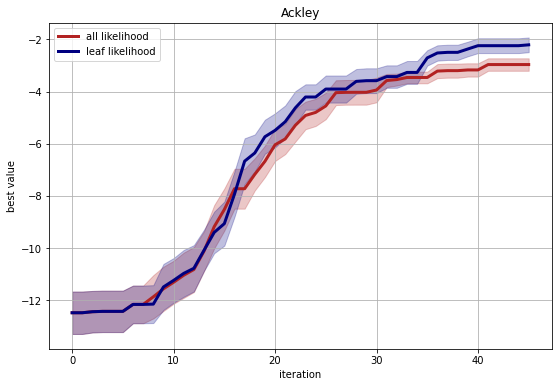

In [ ]:
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

with open('/content/drive/My Drive/treed_BO/treed_BO_all_llk_Ackley.txt', 'r') as f:
    total_record_BO_zeromean_all_llk = np.loadtxt(f)

with open('/content/drive/My Drive/treed_BO/treed_BO_leaf_llk_Ackley.txt', 'r') as f:
    total_record_BO_zeromean_leaf_llk = np.loadtxt(f)

plt.figure(figsize=(9,6))

N = 20

total_record = np.array(total_record_BO_zeromean_all_llk)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='firebrick',label = 'all likelihood')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='firebrick',alpha=0.25)


total_record = np.array(total_record_BO_zeromean_leaf_llk)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='navy',label = 'leaf likelihood')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='navy',alpha=0.25)

plt.xlabel('iteration')
plt.ylabel('best value')
plt.title('Ackley')
plt.grid()
plt.legend()


plt.savefig("Ackley_allleaf.png")
files.download("Ackley_allleaf.png") 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

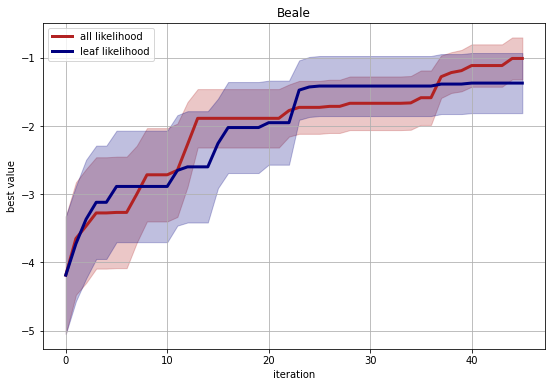

In [ ]:
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

with open('/content/drive/My Drive/treed_BO/treed_BO_all_llk_Beale.txt', 'r') as f:
    total_record_BO_zeromean_all_llk = np.loadtxt(f)

with open('/content/drive/My Drive/treed_BO/treed_BO_leaf_llk_Beale.txt', 'r') as f:
    total_record_BO_zeromean_leaf_llk = np.loadtxt(f)


plt.figure(figsize=(9,6))

N = 20

total_record = np.array(total_record_BO_zeromean_all_llk)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='firebrick',label = 'all likelihood')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='firebrick',alpha=0.25)


total_record = np.array(total_record_BO_zeromean_leaf_llk)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='navy',label = 'leaf likelihood')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='navy',alpha=0.25)

plt.xlabel('iteration')
plt.ylabel('best value')
plt.title('Beale')
plt.grid()
plt.legend()


plt.savefig("Beale_allleaf.png")
files.download("Beale_allleaf.png") 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

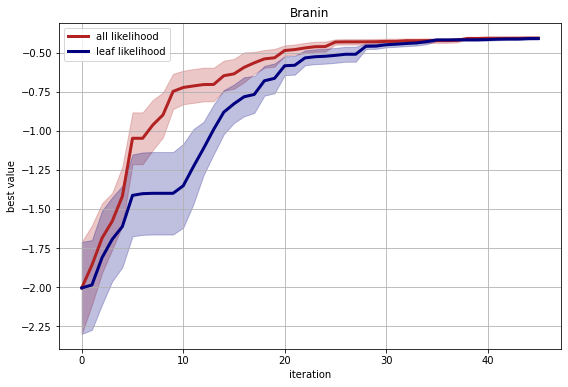

In [ ]:
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

with open('/content/drive/My Drive/treed_BO/treed_BO_all_llk_Branin.txt', 'r') as f:
    total_record_BO_zeromean_all_llk = np.loadtxt(f)

with open('/content/drive/My Drive/treed_BO/treed_BO_leaf_llk_Branin.txt', 'r') as f:
    total_record_BO_zeromean_leaf_llk = np.loadtxt(f)


plt.figure(figsize=(9,6))

N = 20

total_record = np.array(total_record_BO_zeromean_all_llk)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='firebrick',label = 'all likelihood')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='firebrick',alpha=0.25)


total_record = np.array(total_record_BO_zeromean_leaf_llk)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='navy',label = 'leaf likelihood')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='navy',alpha=0.25)

plt.xlabel('iteration')
plt.ylabel('best value')
plt.title('Branin')
plt.grid()
plt.legend()

plt.savefig("Branin_allleaf.png")
files.download("Branin_allleaf.png") 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

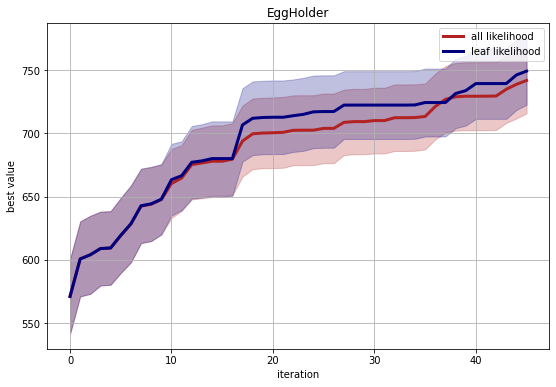

In [ ]:
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

with open('/content/drive/My Drive/treed_BO/treed_BO_all_llk_EggHolder.txt', 'r') as f:
    total_record_BO_zeromean_all_llk = np.loadtxt(f)

with open('/content/drive/My Drive/treed_BO/treed_BO_leaf_llk_EggHolder.txt', 'r') as f:
    total_record_BO_zeromean_leaf_llk = np.loadtxt(f)

plt.figure(figsize=(9,6))

N = 20

total_record = np.array(total_record_BO_zeromean_all_llk)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='firebrick',label = 'all likelihood')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='firebrick',alpha=0.25)


total_record = np.array(total_record_BO_zeromean_leaf_llk)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,color='navy',label = 'leaf likelihood')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N) ,color='navy',alpha=0.25)

plt.xlabel('iteration')
plt.ylabel('best value')
plt.title('EggHolder')
plt.grid()
plt.legend()

plt.savefig("EggHolder_allleaf.png")
files.download("EggHolder_allleaf.png") 